In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.9.2


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.8 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

from PIL import Image

from imageio import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [ ]:
annotations = pd.read_csv('/content/gdrive/My Drive/archive/annotations.csv')
candidates = pd.read_csv('/content/gdrive/My Drive/archive/candidates.csv')

In [ ]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

In [ ]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/archive/seg-lungs-LUNA16/seg-lungs-LUNA16/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [ ]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

SyntaxError: ignored

In [ ]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [ ]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [ ]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [ ]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [ ]:
X_train.to_pickle('/content/gdrive/My Drive/archive/preprocessed_data/traindata')
X_test.to_pickle('/content/gdrive/My Drive/archive/preprocessed_data/testdata')
X_val.to_pickle('/content/gdrive/My Drive/archive/preprocessed_data/valdata')

In [ ]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [ ]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

In [ ]:
import scipy.misc

In [ ]:
import cv2

In [ ]:
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

Original shape of input image:  (50, 50)


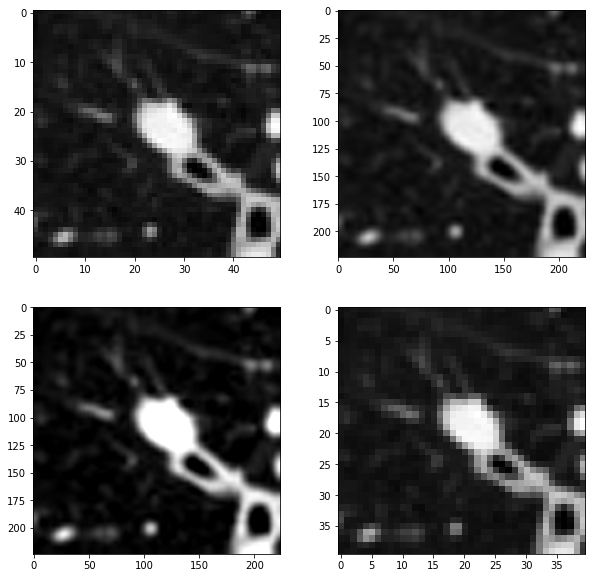

In [ ]:
dirName = '/content/gdrive/My Drive/archive/data/train/'
plt.figure(figsize = (10,10))
inp = imread(dirName + '1234.jpg')
print ("Original shape of input image: ", inp.shape)
plt.subplot(221)
plt.imshow(inp, cmap='gray')
plt.grid(False)

inp = PreProcessing(inp).upsample_data()
Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2, cmap='gray')
plt.grid(False)

inp3 = ImageEnhance.Contrast(Image.fromarray(inp))
contrast = 1.5
inp3 = inp3.enhance(contrast)
plt.subplot(223)
plt.imshow(inp3, cmap='gray')
plt.grid(False)

inp4 = Pp.downsample_data()
plt.subplot(224)
plt.imshow(inp4,cmap='gray')
plt.grid(False)

In [ ]:
inp.shape

(224, 224)

In [ ]:
inp.dtype

dtype('uint8')

In [ ]:
y_train_new.values.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
dirName 

'/content/gdrive/My Drive/archive/data/train/'

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2459476.jpg'],
      dtype='<U80')

In [ ]:
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2459476.jpg'],
      dtype='<U80')

In [ ]:
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
traindata

array([(b'/content/gdrive/My Drive/lungcancer/', 0),
       (b'/content/gdrive/My Drive/lungcancer/', 0),
       (b'/content/gdrive/My Drive/lungcancer/', 0), ...,
       (b'/content/gdrive/My Drive/lungcancer/', 1),
       (b'/content/gdrive/My Drive/lungcancer/', 1),
       (b'/content/gdrive/My Drive/lungcancer/', 1)],
      dtype=[('var1', 'S36'), ('var2', '<i8')])

In [ ]:
import h5py
h5f = h5py.File('/content/gdrive/My Drive/archive/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/archive/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [ ]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [ ]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

In [ ]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)

In [ ]:
print(X_train_processing.shape)
print(X_val_processing.shape)

(5187, 50, 50)
(1297, 50, 50)


In [ ]:
print(X_train_processing.dtype)
print(X_val_processing.dtype)

float32
float32


In [ ]:
img_test = X_train_processing[1000]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [ ]:
print(Y_train_labels[1000])

[1. 0.]


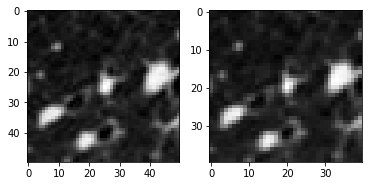

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled,cmap='gray')

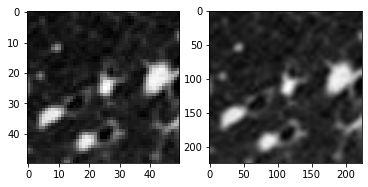

In [ ]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_upsampled,cmap='gray')

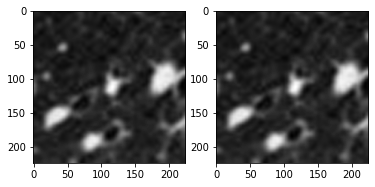

In [ ]:
img_test_subtracted_mean = PreProcessing(img_test_upsampled).subtract_mean()
plt.subplot(121)
plt.imshow(img_test_upsampled,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_subtracted_mean,cmap='gray')

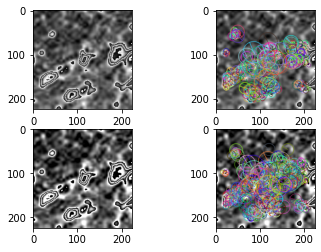

In [ ]:
import cv2
brisk = cv2.BRISK_create(50)
img_BRISK_1 = img_test_upsampled.copy()
rgb = cv2.cvtColor(img_BRISK_1, cv2.COLOR_GRAY2RGB)
img_BRISK_2 = rgb*1000
img_BRISK_3 = np.array(img_BRISK_2, dtype=np.uint8)
img_contr_copy = img_BRISK_3.copy()

plt.subplot(221)
plt.imshow(img_BRISK_3, cmap='gray')
kpts_1, des_1 = brisk.detectAndCompute(img_BRISK_3, None)

image_BRISK_1 = cv2.drawKeypoints(image=img_BRISK_3, outImage=img_BRISK_3, keypoints=kpts_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(222)
plt.imshow(image_BRISK_1, cmap='gray')


# with enhanced contrast

inp_contr = ImageEnhance.Contrast(Image.fromarray(img_contr_copy))
contrast = 1.5
img_contr = inp_contr.enhance(contrast)
plt.subplot(223)
plt.imshow(img_contr, cmap='gray')
img_BRISK_4 = np.array(img_contr)
kpts_2, des_2 = brisk.detectAndCompute(img_BRISK_4, None)

image_BRISK_2 = cv2.drawKeypoints(image=img_BRISK_4, outImage=img_BRISK_4, keypoints=kpts_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(224)
plt.imshow(image_BRISK_2, cmap='gray')

In [ ]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [ ]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [ ]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


In [ ]:
h5f2 = h5py.File('/content/gdrive/My Drive/archive/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [ ]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)